In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
import numba
import cv2 
import random


from detection_utils.boxes import non_max_suppression
from detection_utils.metrics import compute_recall, compute_precision
from detection_utils.pytorch import softmax_focal_loss

In [2]:
@numba.njit
def box_overlaps(
        predicted,
        truth,
        eps = 1e-12,
):
    N = predicted.shape[0]
    K = truth.shape[0]
    ious = np.zeros((N, K), dtype=np.float32)
    print(predicted.shape, truth.shape)  # I added this
    for k in range(K):
        truth_area = (truth[k, 2] - truth[k, 0]) * (truth[k, 3] - truth[k, 1])
        for n in range(N):
            width_overlap = min(predicted[n, 2], truth[k, 2]) - max(predicted[n, 0], truth[k, 0])
            if width_overlap > 0:
                height_overlap = min(predicted[n, 3], truth[k, 3]) - max(predicted[n, 1], truth[k, 1])
                if height_overlap > 0:
                    overlap_area = width_overlap * height_overlap
                    box_area = (predicted[n, 2] - predicted[n, 0]) * (predicted[n, 3] - predicted[n, 1])
                    union = box_area + truth_area - overlap_area
                    ious[n, k] = overlap_area / (union + eps)
    return ious

def generate_targets(
        anchor_boxes,
        truth_boxes,
        labels,
        pos_thresh= 0.3,
        neg_thresh= 0.2,
        eps = 1e-12,
):
    if truth_boxes.size == 0:
        targets_reg = np.zeros_like(anchor_boxes, dtype=np.float32)
        targets_cls = np.zeros(anchor_boxes.shape[0], dtype=np.int64)
        return targets_cls, targets_reg
    ious = box_overlaps(anchor_boxes, truth_boxes)  # NxK
    max_ious = ious.max(axis=1)                     # N IoUs
    max_idxs = ious.argmax(axis=1)                  # N indices
    target_boxes = truth_boxes[max_idxs]
    target_centers = (target_boxes[:, :2] + target_boxes[:, 2:]) / 2
    anchor_centers = (anchor_boxes[:, :2] + anchor_boxes[:, 2:]) / 2
    target_wh = target_boxes[:, 2:] - target_boxes[:, :2]
    anchor_wh = anchor_boxes[:, 2:] - anchor_boxes[:, :2]
    xy = (target_centers - anchor_centers) / anchor_wh
    wh = np.log(target_wh / (anchor_wh + eps) + eps)
    targets_reg = np.hstack([xy, wh])
    targets_cls = labels[max_idxs]
    targets_cls[max_ious < pos_thresh] = -1
    targets_cls[max_ious < neg_thresh] = 0
    targets_cls = targets_cls.reshape(-1).astype(np.int32)
    targets_reg = targets_reg.reshape(-1, 4).astype(np.float32)
    return targets_cls, targets_reg

In [3]:
def add_character(im, x, y, size, char):
    assert x-size/2 >= 0 and x+size/2 <= im[0].size and y-size/2 >= 0 and y+size/2 <= im[1].size
    raze = cv2.imread("Characters/" + char + ".png")
    raze = cv2.resize(raze, (size, size))
    non_zero = raze > np.array([0, 0, 0])
    new_im = im[y-size//2 : y+size//2, x-size//2 : x+size//2]
    new_im[non_zero] = raze[non_zero]
    im[y-size//2 : y+size//2, x-size//2 : x+size//2, :] = new_im
    return im

In [4]:
adds = np.array(["Breach", "Brimstone", "Cypher", "Jett", "Omen", "Phoenix", "Raze", "Reyna", "Sage", "Sova", "Viper"])

In [5]:
raze = cv2.imread("Characters/" + "Raze" + ".png")[:, :, ::-1]
raze = cv2.resize(raze, (100, 100))
print(raze.shape)
non_zero = raze > np.array([0, 0, 0])

(100, 100, 3)


In [6]:
def add_rands(im):
    num = random.randint(1, 5)
    l = random.sample(range(0, 10), num)
    chars = adds[l]
    im = cv2.resize(cv2.imread("Maps/" + im + ".png"), (256, 256))
    boxes = []
    for char in chars:
        x = np.random.randint(50, 200)
        y = np.random.randint(50, 200)
        size = np.random.randint(8, 16)*2
        add_character(im, x, y, size, char)
        box = [[x-size//2, y-size//2], [x+size//2, y+size//2]]
        boxes.append(box)
    boxes = np.array(boxes)
    return im, boxes, chars

In [7]:
images_all = []
boxes_all = []
labels_all = []

In [8]:
for i in range(100):
    im, boxes, labels = add_rands("Haven")
    images_all.append(im)
    boxes_all.append(boxes)
    labels_all.append(labels)

In [9]:
"""for i in range(5, 10):
    im, boxes, labels = add_rands("Bind")
    images_all.append(im)
    boxes_all.append(boxes)
    labels_all.append(labels)"""

'for i in range(5, 10):\n    im, boxes, labels = add_rands("Bind")\n    images_all.append(im)\n    boxes_all.append(boxes)\n    labels_all.append(labels)'

In [10]:
"""for i in range(10, 15):
    im, boxes, labels = add_rands("Split")
    images_all.append(im)
    boxes_all.append(boxes)
    labels_all.append(labels)"""

'for i in range(10, 15):\n    im, boxes, labels = add_rands("Split")\n    images_all.append(im)\n    boxes_all.append(boxes)\n    labels_all.append(labels)'

In [11]:
chars = {"Breach":1, "Brimstone":2, "Cypher":3, "Jett":4, "Omen":5, "Phoenix":6, "Raze":7, "Reyna":8, "Sage":9, "Sova":10, "Viper":11}
for i in range(len(labels_all)):
    for j in range(len(labels_all[i])):
        labels_all[i][j] = chars[labels_all[i][j]]

In [12]:
# np.save("data/train/images", np.array(images_all)/255)
# np.save("data/train/boxes", np.array(boxes_all), allow_pickle=True)
# np.save("data/train/labels", np.array(labels_all), allow_pickle=True)

In [13]:
images = np.array(images_all)/255
boxes = np.array(boxes_all)
labels = np.array(labels_all)

In [14]:
for i in range(len(boxes)):
    boxes[i] = boxes[i].reshape(-1,4)

In [15]:
label = labels[1]

In [16]:
label[1]

'7'

In [17]:
for i in range(len(label)):
    label[i] = str(label[i])

In [18]:
char_inv = {'1':"Breach", '2':"Brimstone", '3':"Cypher", '4':"Jett", '5':"Omen", "6":"Phonix", "7":"Raze", "8":"Reyna","9":"Sage","10":"Sova","11":"Viper"}

In [19]:
import random
i =random.randint(0,len(images)) 
label = labels[i]

[ 98  75 128 105]
['7' '6' '2']
[ 74 173 104 203]
['7' '6' '2']
[ 97 104 119 126]
['7' '6' '2']


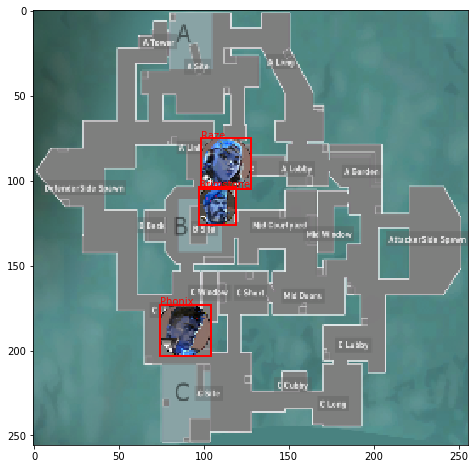

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(images[i])
for idx, box in enumerate(boxes[i]):
    print(box)
    print(label)
    ax.add_patch(Rectangle(box[:2], *(box[2:] - box[:2]), color='r', fill=None, lw=2))
    ax.annotate(char_inv[str(label[idx])], box[:2], color='r')


In [21]:
print(images.shape, boxes.shape, labels.shape)
print(boxes[1].shape, labels[1].shape)

(100, 256, 256, 3) (100,) (100,)
(5, 4) (5,)


In [22]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import torch
from torch import nn
import torch.nn.functional as F
import numba

from detection_utils.boxes import non_max_suppression
from detection_utils.metrics import compute_recall, compute_precision
from detection_utils.pytorch import softmax_focal_loss

In [23]:
batch_size = 10  # feel free to manipulate this as needed for GPU memory or as desired

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


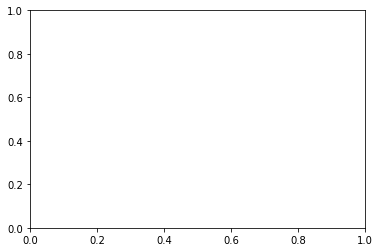

In [24]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

In [25]:
train_images, train_boxes, train_labels = images, boxes, labels
val_images, val_boxes, val_label = images, boxes, labels
train_images = torch.tensor(train_images.transpose(0, 3, 1, 2)).float().to(device)
val_images = torch.tensor(val_images.transpose(0, 3, 1, 2)).float().to(device)

In [26]:
# import paramiko

# host = "173.48.66.87"
# port = 22
# username = "dios"
# password = "dios"
# command = 'echo "Hello Dios" >> newfile.py'


# client = paramiko.Transport((host, port))
# client.connect(username=username, password=password)

# stdout_data = []
# stderr_data = []
# session = client.open_channel(kind='session')
# session.exec_command(command)

In [27]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3, padding=1)
        self.conv2 = nn.Conv2d(10, 20, 3, padding=1)
        self.conv3 = nn.Conv2d(20, 30, 3, padding=1)
        self.conv4 = nn.Conv2d(30, 40, 3, padding=1)
        
        self.classification = nn.Conv2d(40, 12, 1) # background / rectangle / triangle / circle
        self.regression = nn.Conv2d(40, 4, 1)
        
        for layer in (self.conv1, self.conv2, self.conv3, self.conv4,
                     self.classification, self.regression):
            nn.init.xavier_normal_(layer.weight, np.sqrt(2))
            nn.init.constant_(layer.bias, 0)

        nn.init.constant_(self.classification.bias[0], -4.6)  # rougly -log((1-π)/π) for π = 0.01
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        
        classifications = self.classification(x).permute(0, 2, 3, 1)                          # (N, R, C, # classes)
        classifications = classifications.reshape(x.shape[0], -1, classifications.shape[-1])  # (N, R*C, # classes)
        regressions = self.regression(x).permute(0, 2, 3, 1)                                  # (N, R, C, # classes)
        regressions = regressions.reshape(x.shape[0], -1, 4)                                  # (N, R*C, 4)
        return classifications, regressions

In [28]:
anchor_boxes = []
for y in range(0, train_images.shape[2], 16):
    for x in range(0, train_images.shape[3], 16):
        anchor_boxes.append(np.array([-16, -16, 16, 16]) + np.array([x, y, x, y]))
anchor_boxes = np.vstack(anchor_boxes)
# anchor_boxes are in xyxy format

In [29]:
for i in range(len(train_boxes)):
    train_boxes[i] = train_boxes[i].reshape(-1, 4)

for i in range(len(val_boxes)):
    val_boxes[i] = val_boxes[i].reshape(-1, 4)

In [30]:
train_cls_targs, train_reg_targs = zip(*(generate_targets(anchor_boxes, bxs, lbls, 0.2, 0.1)
                                         for bxs, lbls in zip(train_boxes, train_labels)))
# val_cls_targs, val_reg_targs = zip(*(generate_targets(anchor_boxes, bxs, lbls, 0.2, 0.1) 
#                                      for bxs, lbls in zip(val_boxes, val_labels)))

# For convenience (and to minimize data transfers) we'll shove all of this onto our
# device as well. This only takes a couple of megabytes of GPU memory
train_reg_targs = torch.tensor(train_reg_targs).float().to(device)
train_cls_targs = torch.tensor(train_cls_targs).long().to(device)
# val_reg_targs = torch.tensor(val_reg_targs).float().to(device)
# val_cls_targs = torch.tensor(val_cls_targs).long().to(device)

(256, 4) (4, 4)
(256, 4) (5, 4)
(256, 4) (1, 4)
(256, 4) (4, 4)
(256, 4) (3, 4)
(256, 4) (1, 4)
(256, 4) (5, 4)
(256, 4) (4, 4)
(256, 4) (2, 4)
(256, 4) (3, 4)
(256, 4) (3, 4)
(256, 4) (3, 4)
(256, 4) (1, 4)
(256, 4) (3, 4)
(256, 4) (5, 4)
(256, 4) (3, 4)
(256, 4) (3, 4)
(256, 4) (1, 4)
(256, 4) (1, 4)
(256, 4) (1, 4)
(256, 4) (3, 4)
(256, 4) (2, 4)
(256, 4) (1, 4)
(256, 4) (4, 4)
(256, 4) (2, 4)
(256, 4) (4, 4)
(256, 4) (3, 4)
(256, 4) (2, 4)
(256, 4) (2, 4)
(256, 4) (3, 4)
(256, 4) (1, 4)
(256, 4) (4, 4)
(256, 4) (4, 4)
(256, 4) (1, 4)
(256, 4) (3, 4)
(256, 4) (1, 4)
(256, 4) (1, 4)
(256, 4) (3, 4)
(256, 4) (2, 4)
(256, 4) (1, 4)
(256, 4) (4, 4)
(256, 4) (5, 4)
(256, 4) (5, 4)
(256, 4) (4, 4)
(256, 4) (3, 4)
(256, 4) (5, 4)
(256, 4) (3, 4)
(256, 4) (4, 4)
(256, 4) (5, 4)
(256, 4) (1, 4)
(256, 4) (5, 4)
(256, 4) (2, 4)
(256, 4) (4, 4)
(256, 4) (4, 4)
(256, 4) (1, 4)
(256, 4) (3, 4)
(256, 4) (3, 4)
(256, 4) (4, 4)
(256, 4) (4, 4)
(256, 4) (1, 4)
(256, 4) (2, 4)
(256, 4) (1, 4)
(256, 4)

In [31]:
# our loss function is a combination of focal loss for classification
# and smooth L1 (Huber) loss for regression
def loss(class_predictions, regression_predictions, class_targets, regression_targets):
    class_targets = class_targets.reshape(-1)
    regression_targets = regression_targets.reshape(-1, 4)
    class_predictions = class_predictions.reshape(-1, class_predictions.shape[-1])
    regression_predictions = regression_predictions.reshape(-1, 4)

    regression_loss = torch.tensor(0).float()
    mask = torch.squeeze(class_targets > 0)
    num_foreground = mask.sum().item()
    if mask.numel() > 0:
        regression_loss = F.smooth_l1_loss(
            regression_predictions[mask], regression_targets[mask]
        )

    mask = torch.squeeze(class_targets > -1)
    
    # the sum of focal loss terms is normalized by the number
    # of anchors assigned to a ground-truth box
    classification_loss = softmax_focal_loss(
        class_predictions[mask],
        class_targets[mask],
        alpha=0.25,
        gamma=2,
        reduction="sum",
    ) / num_foreground

    return classification_loss, regression_loss

In [32]:
def compute_detections(classifications, regressions, feature_map_width, anchor_box_step, anchor_box_size):
    """ Compute a set of boxes, class predictions, and foreground scores from
        detection model outputs.

    Parameters
    ----------
    classifications : torch.Tensor, shape=(N, R*C, # classes)
        A set of class predictions at each spatial location.

    regressions : torch.Tensor, shape=(N, R*C, 4)
        A set of predicted box offsets, in (x, y, w, h) at each spatial location.

    feature_map_width : int
        The number of pixels in the feature map, along the x direction.

    anchor_box_step : int
        The number of pixels (in image space) between each anchor box.

    anchor_box_size : int
        The side length of the anchor box.

    Returns
    -------
    Tuple[numpy.ndarray shape=(R*C, 4), numpy.ndarray shape=(R*C, 1), numpy.ndarray shape=(R*C,)]
        The (boxes, class predictions, foreground scores) at each spatial location.
    """
    box_predictions = np.empty((len(regressions), 4), dtype=np.float32)
    scores = torch.softmax(classifications, dim=-1).detach().cpu().numpy()
    scores = 1 - scores[:, 0]  # foreground score

    class_predictions = classifications.argmax(dim=-1, keepdim=True).detach().cpu().numpy()
    regressions = regressions.detach().cpu().numpy()

    y, x = np.divmod(np.arange(len(classifications)), feature_map_width, dtype=np.float32)
    x_reg, y_reg, w_reg, h_reg = regressions.T  # transform (R*C, 4) to (4, R*C) for assignment
    x = anchor_box_step * x + anchor_box_size * x_reg
    y = anchor_box_step * y + anchor_box_size * y_reg

    half_w = np.clip(np.exp(w_reg), 0, 10**6) * anchor_box_size / 2
    half_h = np.clip(np.exp(h_reg), 0, 10**6) * anchor_box_size / 2

    box_predictions[:, 0] = x - half_w  # x1
    box_predictions[:, 1] = y - half_h  # y1
    box_predictions[:, 2] = x + half_w  # x2
    box_predictions[:, 3] = y + half_h  # y2

    return box_predictions, class_predictions, scores

In [33]:
def compute_batch_stats(class_predictions, regression_predictions, boxes, labels, feature_map_width,
                        anchor_box_step=16, anchor_box_size=32, threshold=0.5):
    """ Compute the batch statistics (AP and AR) given a batch of predictions and truth.

    Parameters
    ----------
    class_predictions : numpy.ndarray, shape=(N, K, C)
        The predicted class scores of each of N images at each of K anchor boxes.

    regression_predictions : numpy.ndarray, shape=(N, K, 4)
        The predicted regression values of each of N images at each of K anchor boxes.

    boxes : numpy.ndarray, shape=(N,)
        The truth boxes for each image. Note that each of the N elements is of 
        shape (W_i, 4), where W_i is the number of objects in image i.

    labels : numpy.ndarray, shape=(N,)
        The truth labels for each image. Note that each of the N elements is of
        shape (W_i,), where  W_i is the number of objects in image i.

    feature_map_width : int, optional (default=40)
        The width of the feature map.

    anchor_box_step : int, optional (default=16)
        The stride across the image at which anchor boxes are placed.

    anchor_box_size : int, optional (default=32)
        The side length of each anchor box.

    threshold : Real, optional (default=0.5)
        The confidence threshold under which to cull predictions.

    Returns
    -------
    Tuple[List[float], List[float]]
        The (aps, ars) for the images.
    """
    aps, ars = [], []
    for i in range(len(class_predictions)):
        truth_detections = np.hstack((boxes[i], labels[i][:, None]))

        box_preds, class_preds, scores = compute_detections(class_predictions[i], 
                                                            regression_predictions[i],
                                                            feature_map_width, 
                                                            anchor_box_step, 
                                                            anchor_box_size)

        keep_idxs = non_max_suppression(box_preds, scores, 0.3)
        detections = np.hstack((box_preds, class_preds))
        detections = detections[keep_idxs]
        detections = detections[scores[keep_idxs] > threshold]

        aps.append(compute_precision(detections, truth_detections, 0.5))
        ars.append(compute_recall(detections, truth_detections, 0.5))
    return aps, ars

In [34]:
model = Model().to(device)
optim = torch.optim.Adam(model.parameters())

In [35]:
def train_epoch(epoch, batch_size, log_file=None, eval_every=10):
    torch.set_grad_enabled(True)
    model.train()

    idxs = torch.randperm(len(train_images))  # shuffle indices
    for itr, batch in enumerate(
        (slice(i, i + batch_size) for i in range(0, len(train_images), batch_size))
    ):
        batch = idxs[batch]

        class_predictions, regression_predictions = model(train_images[batch])
        aps, ars = compute_batch_stats(
            class_predictions,
            regression_predictions,
            train_boxes[batch],
            train_labels[batch],
            feature_map_width=16,
        )
        total_cls_loss, total_reg_loss = loss(
            class_predictions,
            regression_predictions,
            train_cls_targs[batch],
            train_reg_targs[batch],
        )

        optim.zero_grad()
        (total_cls_loss + total_reg_loss).backward()
        optim.step()


        if log_file is not None:
            log_str = f"Epoch {epoch:03d} batch {itr+1:05d}: "
            log_str += f"Loss {(total_cls_loss + total_reg_loss).item():0.4f}"
            log_str += f" Regression loss {total_reg_loss.item():0.4f}"
            log_str += f" Classification loss {total_cls_loss.item():0.4f}"
            log_str += f" AP {np.mean(aps):0.4f} AR {np.mean(ars):0.4f}"
            log_file.write(log_str + "\n")

        if (itr + 1) % 10 == 0:
            print(f"Epoch {epoch} iteration {itr + 1}", end="\r")

    if epoch % eval_every == 0:
        aps, ars = [], []
        idxs = torch.arange(len(val_images))
        for itr, batch in enumerate(
            (slice(i, i + batch_size) for i in range(0, len(val_images), batch_size))
        ):
            batch = idxs[batch]

            class_predictions, regression_predictions = model(val_images[batch])
            ap, ar = compute_batch_stats(
                class_predictions,
                regression_predictions,
                val_boxes[batch],
                val_labels[batch],
                feature_map_width=16,
            )
            aps += ap
            ars += ar

        print(
            f"Epoch {epoch:03d}  Validation: {np.mean(aps):0.3f} mAP, {np.mean(ars):0.3f} mAR"
        )

In [36]:
val_images = train_images
val_boxes = train_boxes
val_labels = train_labels

In [37]:
train_images.dtype

torch.float32

In [38]:

for i in range(len(train_labels)):
    train_labels[i] = np.array(train_labels[i], dtype=np.float32)

In [39]:
train_labels

array([array([7., 2., 9., 6.], dtype=float32),
       array([ 4.,  7.,  1., 10.,  6.], dtype=float32),
       array([3.], dtype=float32), array([5., 8., 9., 6.], dtype=float32),
       array([1., 2., 7.], dtype=float32), array([6.], dtype=float32),
       array([ 4.,  5.,  1., 10.,  9.], dtype=float32),
       array([7., 5., 1., 3.], dtype=float32),
       array([3., 8.], dtype=float32),
       array([ 3., 10.,  9.], dtype=float32),
       array([1., 7., 8.], dtype=float32),
       array([10.,  4.,  6.], dtype=float32), array([9.], dtype=float32),
       array([ 5.,  8., 10.], dtype=float32),
       array([ 4.,  7.,  6., 10.,  9.], dtype=float32),
       array([7., 9., 5.], dtype=float32),
       array([6., 4., 1.], dtype=float32), array([5.], dtype=float32),
       array([3.], dtype=float32), array([8.], dtype=float32),
       array([7., 6., 2.], dtype=float32), array([2., 8.], dtype=float32),
       array([2.], dtype=float32), array([8., 7., 5., 9.], dtype=float32),
       array([5.,

In [40]:
for i in range(len(train_labels)):
    train_labels[i] = np.array(train_labels[i], dtype=np.int32)
    
for i in range(len(train_boxes)):
    train_boxes[i] = np.array(train_boxes[i], dtype=np.float32)

In [41]:
val_boxes[0]

array([[177.,  60., 195.,  78.],
       [150.,  82., 174., 106.],
       [162., 162., 190., 190.],
       [158., 187., 180., 209.]], dtype=float32)

In [ ]:
with open('log.txt', 'w') as log:
    for epoch in range(1, 751):
        train_epoch(epoch, batch_size, log, eval_every=20)

Epoch 020  Validation: 0.759 mAP, 0.979 mAR
Epoch 040  Validation: 0.770 mAP, 0.993 mAR
Epoch 060  Validation: 0.775 mAP, 0.986 mAR
Epoch 080  Validation: 0.770 mAP, 0.993 mAR
Epoch 100  Validation: 0.757 mAP, 0.990 mAR
Epoch 120  Validation: 0.772 mAP, 0.995 mAR
Epoch 140  Validation: 0.739 mAP, 0.990 mAR
Epoch 160  Validation: 0.765 mAP, 0.994 mAR
Epoch 180  Validation: 0.774 mAP, 0.990 mAR
Epoch 200  Validation: 0.760 mAP, 0.993 mAR
Epoch 220  Validation: 0.764 mAP, 0.996 mAR
Epoch 240  Validation: 0.773 mAP, 0.993 mAR
Epoch 260  Validation: 0.758 mAP, 0.998 mAR
Epoch 280  Validation: 0.745 mAP, 0.997 mAR
Epoch 300  Validation: 0.757 mAP, 1.000 mAR
Epoch 320  Validation: 0.777 mAP, 0.998 mAR
Epoch 340  Validation: 0.784 mAP, 0.989 mAR
Epoch 360  Validation: 0.772 mAP, 0.996 mAR


In [43]:
torch.save(model.state_dict(), 'saved_model_state1.pt')

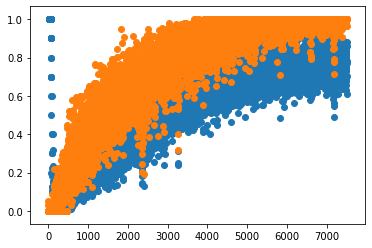

In [44]:
losses, aps, ars = [], [], []
with open('log.txt') as f:
    for line in f:
        line = line.split()
        losses.append(float(line[5]))
        aps.append(float(line[-3]))
        ars.append(float(line[-1]))

fig, ax = plt.subplots()
ax.scatter(range(len(aps)), aps)
ax.scatter(range(len(ars)), ars)

In [45]:
characters = ["","Breach", "Brimstone", "Cypher", "Jett", "Omen", "Phoenix", "Raze", "Reyna", "Sage", "Sova", "Viper"]

In [46]:
val_images = train_images
#val_images = val_images[:,:,:,::-1]

In [47]:
def visualize_random_image(model, threshold=0, idx=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    idx = np.random.randint(len(val_images)) if idx is None else idx
    print(idx)
    img = torch.tensor(val_images[idx])
    ax.imshow(img.permute(1,2,0).cpu())
    ax.axis('off')
    print(img[np.newaxis].shape)

    out_cls, out_reg = model(img[np.newaxis])
    box_preds, class_preds, scores = compute_detections(out_cls.squeeze(), 
                                                        out_reg.squeeze(), 
                                                        feature_map_width=16,
                                                        anchor_box_step=16, 
                                                        anchor_box_size=32)
    

    keep = scores > threshold
    box_preds = box_preds[keep]
    class_preds = class_preds[keep]
    scores = scores[keep]
    keep_idxs = non_max_suppression(box_preds, scores, threshold=0.1)
    box_preds = box_preds[keep_idxs]
    class_preds = class_preds[keep_idxs]

    for class_pred, box_pred in zip(class_preds, box_preds):
        if class_pred > 0:
            x1, y1, x2, y2 = box_pred
            ax.add_patch(Rectangle((x1, y1), x2 - x1, y2 - y1, color='r', fill=None, lw=2))
            label = characters[int(class_pred)]
            label = '' if int(class_pred) == 0 else label
            """
            label = 'Breach' if label == 1 else label
            label = 'Brimstone' if label == 2 else label
            label = 'Cypher' if label == 3 else label
            label = 'Jett' if label == 4 else label
            label = 'Omen' if label == 5 else label
                        
            label = ''
            """
            ax.annotate(label, (x1, y1), color='r', fontsize=24)

0
torch.Size([1, 3, 256, 256])


C:\Users\daani\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


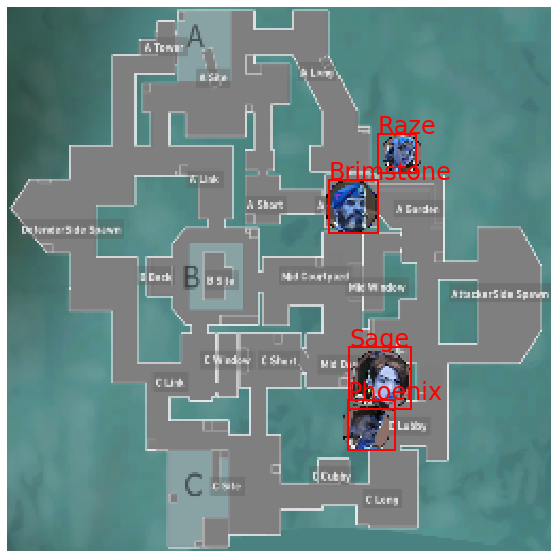

In [63]:
visualize_random_image(model, idx=None)


In [49]:
torch.save(model.state_dict(), 'saved_model_state.pt')

In [50]:
print(train_images.shape)

torch.Size([100, 3, 256, 256])
